# La Liga Data Analysis

## Package Requirements & Database

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from tabulate import tabulate

In [3]:
with sqlite3.connect("../laliga.sqlite") as con:
    df=pd.read_sql_query("SELECT * FROM Matches",con)
    dr=pd.read_sql_query("SELECT * FROM Predictions",con)

## Exercises

### Exercise 1
**Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or there’s a tie) of all matches in the data. Write in the plot the percentage of each category.**

As can be seen in the pie chart below, it is indeed true that it is more likely for the home team to win, with a 52.8% chance.

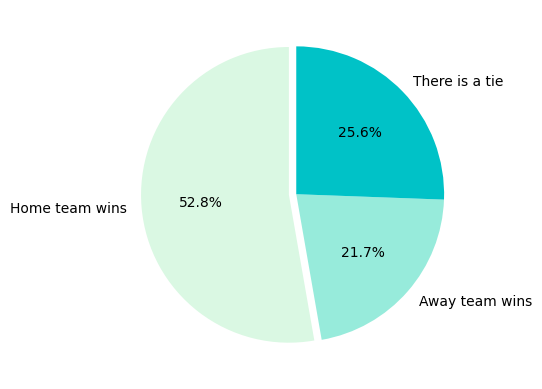

In [44]:
df = df.dropna(subset=['score'])

df["score_home_team"] = df["score"].str.split(":").str[0].astype(float)
df["score_away_team"] = df["score"].str.split(":").str[1].astype(float)

home_wins = (df['score_home_team'] > df['score_away_team']).sum()
away_wins = (df['score_home_team'] < df['score_away_team']).sum()
ties = (df['score_home_team'] == df['score_away_team']).sum()

sizes = [home_wins, away_wins, ties]
labels = ['Home team wins', 'Away team wins', 'There is a tie']
explode = (0.05, 0.0, 0.0)
colors = ['#daf8e3', '#97ebdb', '#00c2c7']

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

plt.show()

### Exercise 2

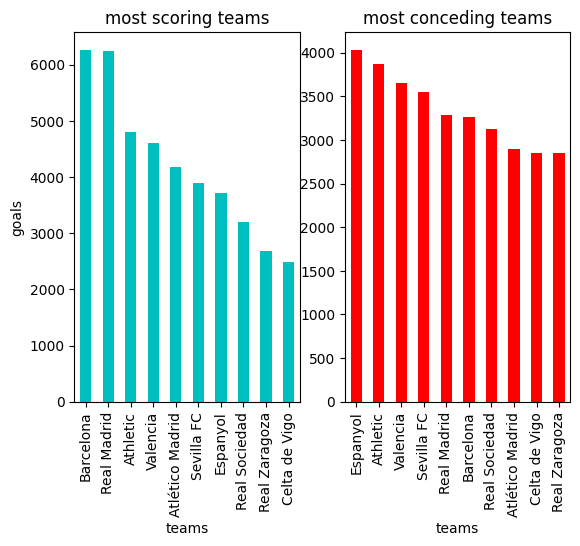

C:\Users\sofia\AppData\Local\Temp\ipykernel_35860\3650855448.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_division['score_difference'] = np.abs(df_first_division["score_home_team"] - df_first_division["score_away_team"])
C:\Users\sofia\AppData\Local\Temp\ipykernel_35860\3650855448.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_division['game_name'] = df_first_division["home_team"] + ' vs ' + df_first_division["away_team"]


In [25]:
df_first_division = df[df['division'] == 1]

goals_scored = df_first_division.groupby('home_team')['score_home_team'].sum() + df_first_division.groupby('away_team')['score_away_team'].sum()
top_scorers = goals_scored.sort_values(ascending=False).head(10)

goals_conceded = df_first_division.groupby('home_team')['score_away_team'].sum() + df_first_division.groupby('away_team')['score_home_team'].sum()
top_conceders = goals_conceded.sort_values(ascending=False).head(10)

plt.subplot(1, 2, 1)
top_scorers.plot(x='nombre', y='valor', kind='bar',color='c')
plt.xlabel('teams')
plt.ylabel('goals')
plt.title('most scoring teams')

plt.subplot(1, 2, 2)
top_conceders.plot(x='nombre', y='valor', kind='bar',color='r')
plt.xlabel('teams')
plt.title('most conceding teams')
plt.show()

df_first_division['score_difference'] = np.abs(df_first_division["score_home_team"] - df_first_division["score_away_team"])
df_first_division['game_name'] = df_first_division["home_team"] + ' vs ' + df_first_division["away_team"]
differences= df_first_division.iloc[:,-2:].sort_values(by='score_difference',ascending=False).head(10)

#table = tabulate(differences, headers='keys', tablefmt='pretty', showindex=False)
#print(table)



### Exercise 3

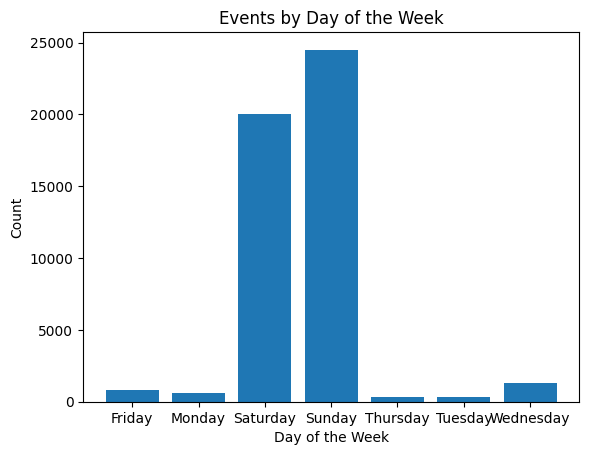

In [21]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df['Day_of_Week'] = df['date'].dt.day_name()

day_of_week_counts = df['Day_of_Week'].value_counts().sort_index()

plt.bar(day_of_week_counts.index, day_of_week_counts)
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Events by Day of the Week')
plt.show()

### Exercise 4

### Exercise 5

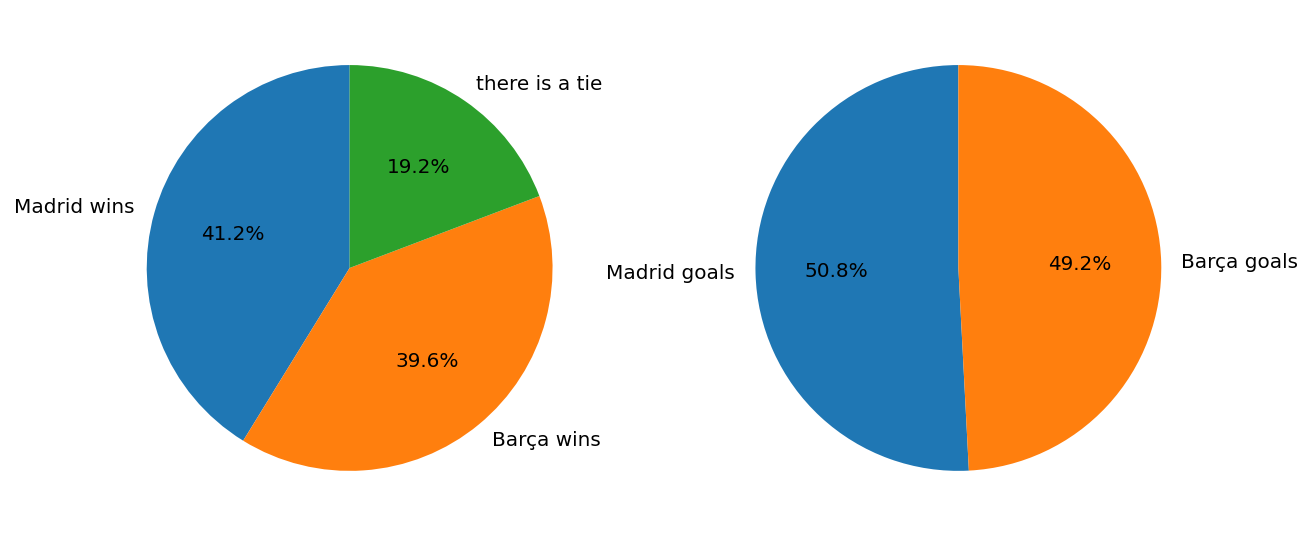

In [23]:
df_home_madrid = df[df['home_team'] == 'Real Madrid'] [df[df['home_team'] == 'Real Madrid'] ['away_team'] == 'Barcelona']
goals_madrid = df_home_madrid['score_home_team'].sum()
df_home_barca = df[df['home_team'] == 'Barcelona'] [df[df['home_team'] == 'Barcelona'] ['away_team'] == 'Real Madrid']
goals_barca = df_home_barca['score_home_team'].sum()

df_bar_vs_mad = pd.concat([df_home_madrid, df_home_barca])

madrid_wins = (df_home_madrid['score_home_team'] > df_home_madrid['score_away_team']).sum() + (df_home_barca['score_home_team'] < df_home_barca['score_away_team']).sum()
barca_wins = (df_home_barca['score_home_team'] > df_home_barca['score_away_team']).sum() + (df_home_madrid['score_home_team'] < df_home_madrid['score_away_team']).sum()
ties = (df_bar_vs_mad['score_home_team'] == df_bar_vs_mad['score_away_team']).sum()

sizes = [madrid_wins, barca_wins, ties]
labels = ['Madrid wins', 'Barça wins', 'there is a tie']

fig = plt.figure(figsize=(10,10),dpi=144)

ax1 = fig.add_subplot(121)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

sizes = [goals_madrid, goals_barca]
labels = ['Madrid goals', 'Barça goals']

ax2 = fig.add_subplot(122)
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.show()

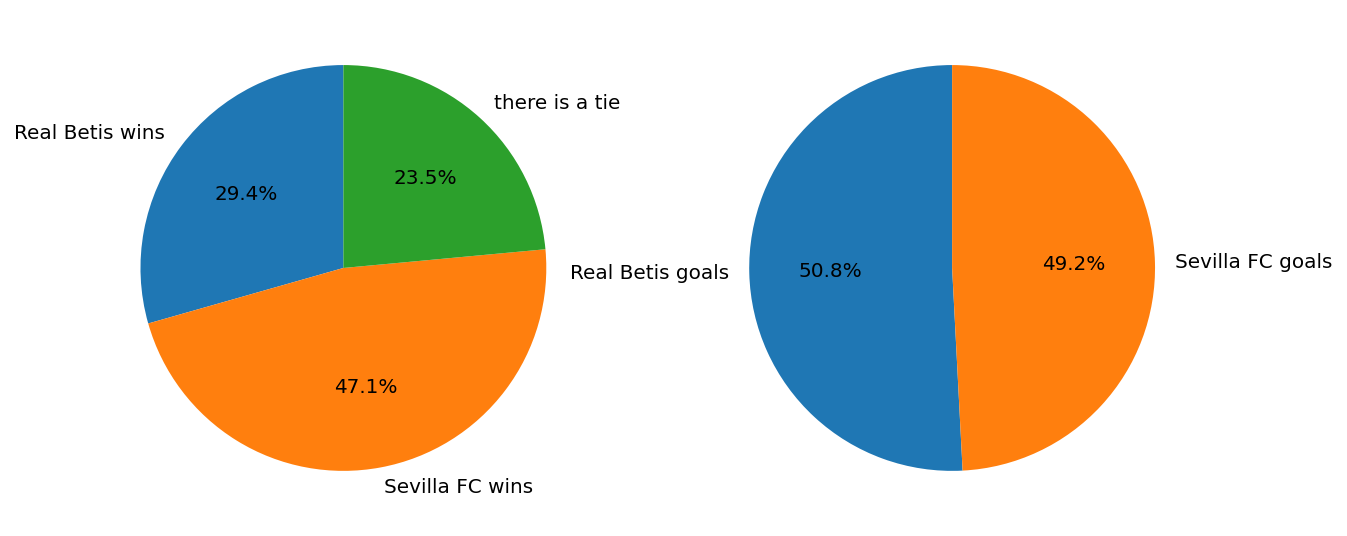

In [24]:
#function exercise 5
def plot_direct_confontations_stats(team1,team2):
    df_home_team1 = df[df['home_team'] == team1] [df[df['home_team'] == team1] ['away_team'] == team2]
    goals_team1 = df_home_team1['score_home_team'].sum()
    df_home_team2 = df[df['home_team'] == team2] [df[df['home_team'] == team2] ['away_team'] == team1]
    goals_team2 = df_home_team2['score_home_team'].sum()

    df_team1_vs_team2 = pd.concat([df_home_team1, df_home_team2])

    team1_wins = (df_home_team1['score_home_team'] > df_home_team1['score_away_team']).sum() + (df_home_team2['score_home_team'] < df_home_team2['score_away_team']).sum()
    team2_wins = (df_home_team2['score_home_team'] > df_home_team2['score_away_team']).sum() + (df_home_team1['score_home_team'] < df_home_team1['score_away_team']).sum()
    ties = (df_team1_vs_team2['score_home_team'] == df_team1_vs_team2['score_away_team']).sum()

    sizes = [team1_wins, team2_wins, ties]
    labels = [team1 + ' wins', team2 + ' wins', 'there is a tie']

    fig = plt.figure(figsize=(10,10),dpi=144)

    ax1 = fig.add_subplot(121)
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

    sizes = [goals_madrid, goals_barca]
    labels = [team1 + ' goals', team2 + ' goals']

    ax2 = fig.add_subplot(122)
    ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.show()

plot_direct_confontations_stats('Real Betis','Sevilla FC')

### Exercise 6

### Exercise 7

### Exercise 8

### Exercise 9

### Exercise 10